<a href="https://colab.research.google.com/github/erendagasan/Eren-Dagasan-Personal/blob/main/ARMIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.7 MB/s eta 0:00:00


In [85]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import yfinance as yf

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = yf.download("META", start="2006-01-01", end="2023-09-10")
stock_data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-05-18,42.049999,45.000000,38.000000,38.230000,38.230000,573576400
2012-05-21,36.529999,36.660000,33.000000,34.029999,34.029999,168192700
2012-05-22,32.610001,33.590000,30.940001,31.000000,31.000000,101786600
2012-05-23,31.370001,32.500000,31.360001,32.000000,32.000000,73600000
2012-05-24,32.950001,33.209999,31.770000,33.029999,33.029999,50237200
...,...,...,...,...,...,...
2023-09-01,299.369995,301.739990,294.470001,296.380005,296.380005,12819800
2023-09-05,297.019989,301.390015,295.510010,300.149994,300.149994,14956000
2023-09-06,301.709991,303.299988,295.660004,299.170013,299.170013,15418100


In [86]:
#Distribution of the dataset
df_close = stock_data['Close']
df_log = np.log(df_close)

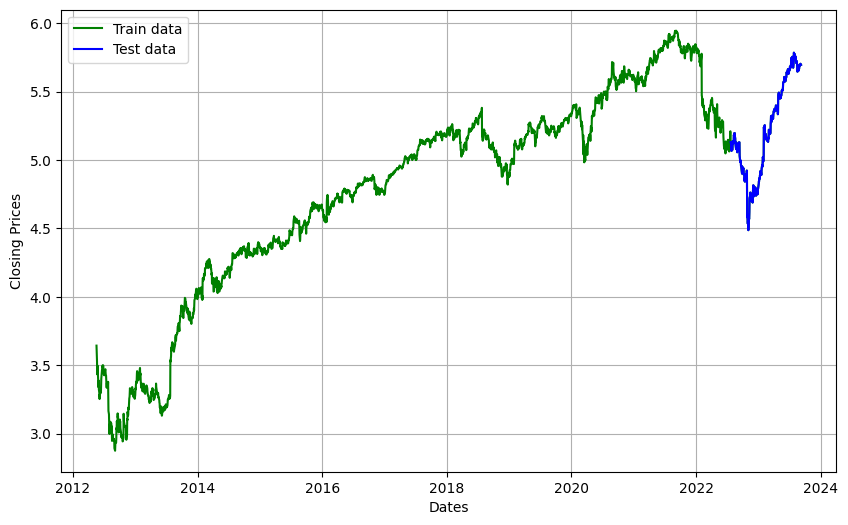

In [87]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [88]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
# model_autoARIMA.plot_diagnostics(figsize=(15,8))
# plt.show()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11748.081, Time=0.34 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-11749.187, Time=0.44 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-11749.041, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11748.062, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-11748.567, Time=1.93 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-11744.161, Time=1.78 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-11747.483, Time=2.39 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-11749.028, Time=0.16 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 7.717 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2557
Model:               SARIMAX(1, 1, 0)   Log Likelihood                5877.594
Date:                Tue, 12 Sep 2023   AIC                         -11749.187
Time:               

In [94]:
from statsmodels.tsa.arima.model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2557
Model:                 ARIMA(1, 1, 0)   Log Likelihood                5876.514
Date:                Tue, 12 Sep 2023   AIC                         -11749.028
Time:                        21:02:27   BIC                         -11737.335
Sample:                             0   HQIC                        -11744.788
                               - 2557                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0340      0.016     -2.125      0.034      -0.065      -0.003
sigma2         0.0006   4.88e-06    120.780      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.00   Jarque-

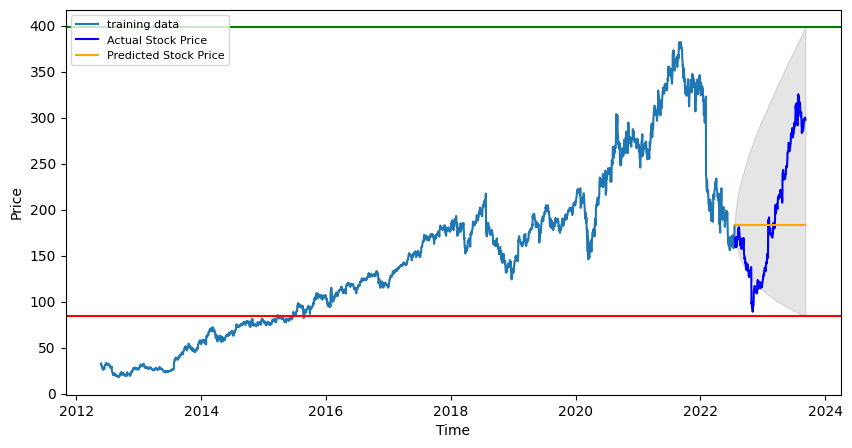

In [95]:
forecast_results = fitted.get_forecast(steps=len(test_data), alpha=0.05)

fc = forecast_results.predicted_mean
conf = forecast_results.conf_int()

fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf.iloc[:, 0], index=test_data.index)
upper_series = pd.Series(conf.iloc[:, 1], index=test_data.index)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(np.exp(train_data), label='training data')
plt.plot(np.exp(test_data), color='blue', label='Actual Stock Price')
plt.plot(test_data.index, np.exp(fc), color='orange', label='Predicted Stock Price')  # Convert back to original scale
plt.fill_between(test_data.index, np.exp(conf.iloc[:, 0]), np.exp(conf.iloc[:, 1]),
                 color='k', alpha=.10)

plt.axhline(np.exp(conf.iloc[:, 1].max()), color="green")
plt.axhline(np.exp(conf.iloc[:, 0].min()), color="red")

plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [96]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc.to_numpy() - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.121786177201655
MAE: 0.30014239054119407
RMSE: 0.34897876325308824
MAPE: 0.05783201478866634


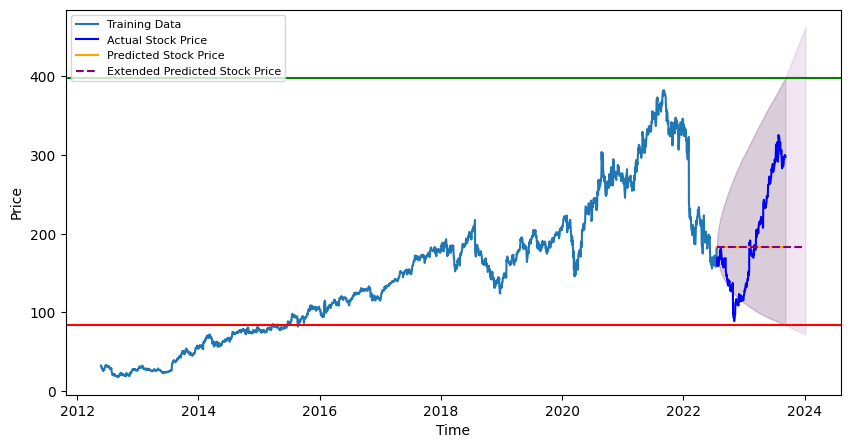

In [98]:
forecast_results = fitted.get_forecast(steps=len(test_data), alpha=0.05)

fc = forecast_results.predicted_mean
conf = forecast_results.conf_int()

fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf.iloc[:, 0], index=test_data.index)
upper_series = pd.Series(conf.iloc[:, 1], index=test_data.index)

# Assuming you already have the forecast_results, fc, conf, fc_series, lower_series, and upper_series

# Extend the time horizon by 30 days
extended_steps = 120
forecast_extended = fitted.get_forecast(steps=len(test_data) + extended_steps, alpha=0.05)

# Extract the extended forecast and confidence intervals
fc_extended = forecast_extended.predicted_mean
conf_extended = forecast_extended.conf_int()

# Create Series for the extended forecast and confidence intervals
fc_series_extended = pd.Series(fc_extended, index=fc_series.index.append(pd.date_range(start=test_data.index[-1] + pd.DateOffset(1), periods=extended_steps)))
lower_series_extended = pd.Series(conf_extended.iloc[:, 0], index=lower_series.index.append(pd.date_range(start=test_data.index[-1] + pd.DateOffset(1), periods=extended_steps)))
upper_series_extended = pd.Series(conf_extended.iloc[:, 1], index=upper_series.index.append(pd.date_range(start=test_data.index[-1] + pd.DateOffset(1), periods=extended_steps)))

# Plot the extended forecast
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(np.exp(train_data), label='Training Data')
plt.plot(np.exp(test_data), color='blue', label='Actual Stock Price')
plt.plot(test_data.index, np.exp(fc), color='orange', label='Predicted Stock Price')
plt.plot(fc_series_extended.index, np.exp(fc_extended), color='purple', linestyle='--', label='Extended Predicted Stock Price')  # Convert back to original scale

# Fill the area between the confidence intervals
plt.fill_between(test_data.index, np.exp(conf.iloc[:, 0]), np.exp(conf.iloc[:, 1]), color='k', alpha=.10)
plt.fill_between(fc_series_extended.index, np.exp(conf_extended.iloc[:, 0]), np.exp(conf_extended.iloc[:, 1]), color='purple', alpha=.10)

# Add horizontal lines for the maximum and minimum bounds of the confidence intervals
plt.axhline(np.exp(conf.iloc[:, 1].max()), color="green")
plt.axhline(np.exp(conf.iloc[:, 0].min()), color="red")

plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()
